# ODE integration, sensitivity and fitting

## second take for the quasi-markov processes

We will use a different low-discrepancy serie today, [based on the golden ratio numbers](http://extremelearning.com.au/unreasonable-effectiveness-of-quasirandom-sequences/)

It is very simple to implement as it is fundamentally similar to the traditional linear congruential generator.

In [286]:
import numpy as np
import scipy.stats as st
import pylab as plt
import pandas as pd
import seaborn as sns

In [329]:
# Using the above nested radical formula for g=phi_d 
# or you could just hard-code it. 
# phi(1) = 1.61803398874989484820458683436563 
# phi(2) = 1.32471795724474602596090885447809 
def phi(d, precision=30): 
    x = 2.00
    for i in range(precision): 
        x = pow(1+x,1/(d+1)) 
    return x

In [334]:
def gaussian_icdf(q):
    return st.norm.isf(q)

def identity(x):
    return x

In [288]:
def a_generate(ndim, Npoints, *, seed=0.5, mapper=identity):
    # get the base for the dimension
    g = phi(ndim) 
    # this is the inizialization constant for the array
    alpha = ((1/g)**np.arange(1, ndim+1))%1  
    # reshaping to allow broadcasting
    alpha = alpha.reshape(1, -1) 
    # just the count of the sequence
    base = np.arange(Npoints).reshape(-1, 1) 
    # perform the actual calculation
    z = seed + alpha*base 
    # tale only the decimal part
    z = z % 1
    # return a mapped version to some distribution
    return mapper(z) 

In [289]:
# this is an iterable version, if you ever need it
def Rϕ(ndim=1, *, seed=0.5, mapper=identity):
    g = phi(ndim) 
    alpha = ((1/g)**np.arange(1, ndim+1))%1        
    z = np.ones(ndim)*seed
    while True:
        yield mapper(z)
        z = (z+alpha) %1 

[]

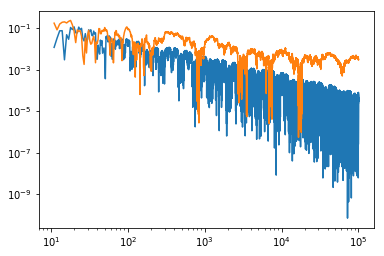

In [291]:
N = 100_000
x_r = a_generate(1, N, mapper=gaussian_icdf)
x_g = plt.randn(N)

n = np.arange(1, len(x_r)+1)
res_r = np.cumsum(x_r)/n
res_g = np.cumsum(x_g)/n

r = 10
plt.plot(n[r:], abs(res_r)[r:])
plt.plot(n[r:], abs(res_g)[r:])
plt.loglog()

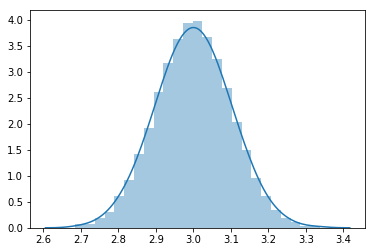

In [314]:
b0 = a_generate(1, 1000, mapper=st.norm(loc=3, scale=0.1).isf)
sns.distplot(b0)

# Basic ODE integration

we can solve the cauchy problem using *scipy* **odeint** function.

this function needs:
* a function that describe the derivative of the system
* the starting state of the system
* the time points over which to integrate
* parameters describing the differential equation, that will be routed to the derivative function

In [ ]:
from scipy.integrate import odeint

In [ ]:
# derivative
def logistic(state, time, α, β):
    N = state
    δN = α*N - β*N**2
    return δN

# time steps
time = np.linspace(0, 1, 2**7+1)

# starting status
N0 = 0.1

# parameters
α = 10
β = 1

we use a base 2 based split for the time scales, to try and save some numerical precision

In [360]:
np.linspace(0, 1, 2**3+1)

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])

In [359]:
res = odeint(logistic, y0=N0, t=time, args=(α, β))

In [362]:
res.shape

(129, 1)

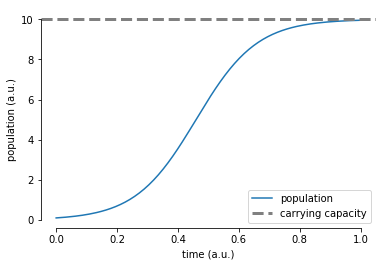

In [363]:
fig, ax = plt.subplots()
ax.plot(time, res, label="population")
ax.set_xlabel("time (a.u.)")
ax.set_ylabel("population (a.u.)")
ax.axhline(α/β, label='carrying capacity', color='gray', linewidth=3, linestyle='--')
ax.legend()
sns.despine(fig, trim=True)

a convenient function is to transform the result of the integration in a pandas dataframe.

this allows us to use it for better visualization using seaborn

In [364]:
def to_df(result, columns, **other_info):
    res_df = pd.DataFrame(result, columns=columns)
    for key, value in other_info.items():
        res_df[key] = value
    return res_df

In [365]:
to_df(res, ['population'], α=α, β=β, time=time).head()

,population,α,β,time
0,0.100000,10,1,0.000000
1,0.108038,10,1,0.007812
2,0.116714,10,1,0.015625
3,0.126079,10,1,0.023438
4,0.136184,10,1,0.031250


In [383]:
mapper = st.norm(loc=[10], scale=0.5).isf
# 50 values around the average value
alphas = a_generate(1, 50, mapper=mapper)
β = 1

time = np.linspace(0, 1, 2**7+1)

results = []
for idx, (α, ) in enumerate(alphas):
    res = odeint(logistic, y0=N0, t=time, args=(α, β))
    res_df = to_df(res, ['population'], α=α, β=β, time=time, simulation_run=idx)
    results.append(res_df)
results = pd.concat(results)

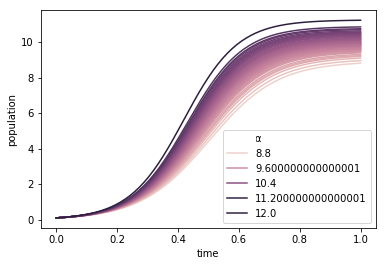

In [384]:
sns.lineplot("time", 'population', data=results, hue='α',
             estimator=None, units='simulation_run')

# SIR model

this is a classical model of the evolution of a disease in a population.

we start with the following variables:

* **S** susceptible, healthy subjects that can be infected
* **I** infected subjects, able to infect susceptible if they meet
* **R** resistant, subjects that have survived the illness and can not be infected again
* **D** deceased, subjects that did not survive the infection

there is one non linear interaction, due to the chance encounter between susceptible and infected.

The easiest way to model this is with a simple product of the two.

We will represent all the populations using normalized concentrations

In [369]:
def SIR_model(state, time, α, β, γ):
    S, I, R, D = state
    δR = + α*I
    δD = + γ*I
    δI = - γ*I - α*I + β*I*S
    δS = - β*I*S
    return δS, δI, δR, δD 
    
time = np.linspace(0, 5, 2**9+1)
state0 = (1.0, 0.001, 0.0, 0.0)
α, β, γ = 1, 10, 0.3

res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))

In [370]:
S_hat, I_hat, R_hat, D_hat = res.T

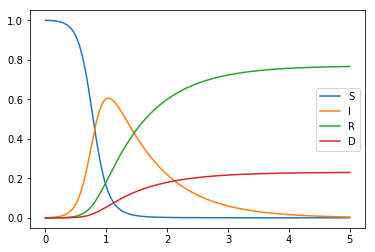

In [371]:
plt.plot(time, S_hat, label='S')
plt.plot(time, I_hat, label='I')
plt.plot(time, R_hat, label='R')
plt.plot(time, D_hat, label='D')

plt.legend()

What happens if we change the value of one of the parameters?

In [374]:
Nexp = 50
results = []
state0 = (1.0, 0.001, 0.0, 0.0)
α, β, γ = 1.0, 10.0, 0.3
α_seq = a_generate(1, Nexp, mapper=st.norm(loc=[1], scale=0.1).isf)

cols = ['S', 'I', 'R', 'D']
for idx, (α, ) in enumerate(α_seq):
    res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
    res_df = to_df(res, cols, N0=N0, α=α, β=β, γ=γ, time=time, simulation_run=idx, type='varying a')
    results.append(res_df)
results = pd.concat(results, ignore_index=True)

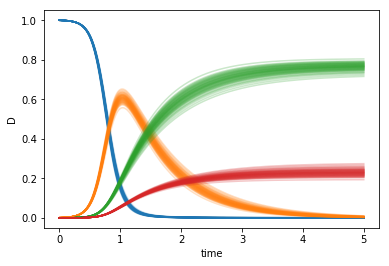

In [375]:
alpha = 0.25
sns.lineplot("time", 'S', data=results, estimator=None, units='simulation_run', alpha=alpha)
sns.lineplot("time", 'I', data=results, estimator=None, units='simulation_run', alpha=alpha)
sns.lineplot("time", 'R', data=results, estimator=None, units='simulation_run', alpha=alpha)
sns.lineplot("time", 'D', data=results, estimator=None, units='simulation_run', alpha=alpha)

we can observe what difference does it makes if we let each parameter fluctuate one at the time, while fixing the others

In [376]:
Nexp = 50
results = []
state0 = (1.0, 0.001, 0.0, 0.0)

α, β, γ = 1.0, 10.0, 0.3
α_seq = a_generate(1, Nexp, mapper=st.norm(loc=[α], scale=α*0.1).isf)
for idx, (α, ) in enumerate(α_seq):
    res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
    res_df = to_df(res, cols, N0=N0, α=α, β=β, γ=γ, time=time, simulation_run=idx, type='varying α')
    results.append(res_df)

α, β, γ = 1.0, 10.0, 0.3
β_seq = a_generate(1, Nexp, mapper=st.norm(loc=[β], scale=β*0.1).isf)
for idx, (β, ) in enumerate(β_seq):
    res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
    res_df = to_df(res, cols, N0=N0, α=α, β=β, γ=γ, time=time, simulation_run=idx, type='varying β')
    results.append(res_df)

α, β, γ = 1.0, 10.0, 0.3
γ_seq = a_generate(1, Nexp, mapper=st.norm(loc=[γ], scale=γ*0.1).isf)
for idx, (γ, ) in enumerate(γ_seq):
    res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
    res_df = to_df(res, cols, N0=N0, α=α, β=β, γ=γ, time=time, simulation_run=idx, type='varying γ')
    results.append(res_df)
results = pd.concat(results, ignore_index=True)

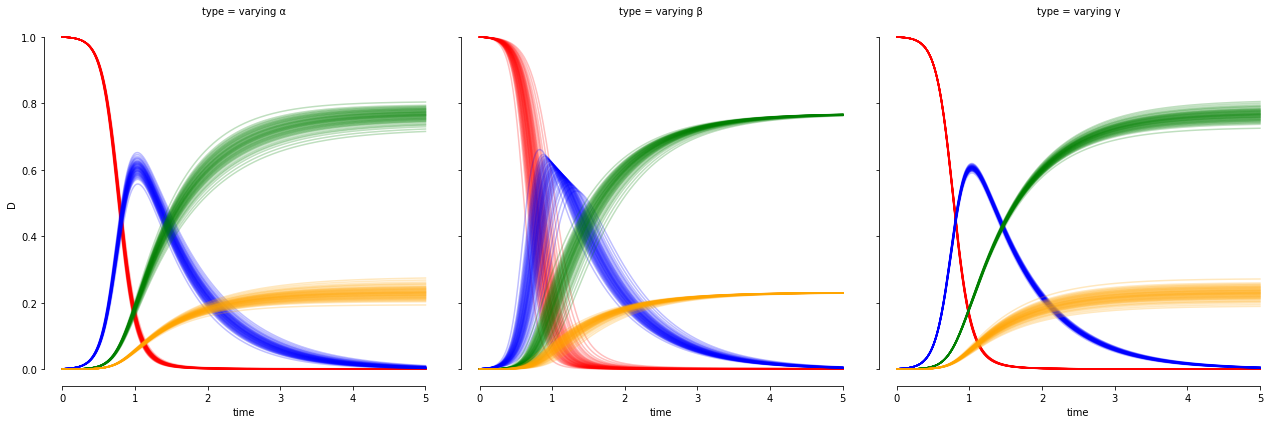

In [378]:
fg = sns.FacetGrid(data=results, col='type', height=6)
fg.map_dataframe(sns.lineplot, "time", 'S', estimator=None, units='simulation_run', alpha=alpha, color='r')
fg.map_dataframe(sns.lineplot, "time", 'I', estimator=None, units='simulation_run', alpha=alpha, color='b')
fg.map_dataframe(sns.lineplot, "time", 'R', estimator=None, units='simulation_run', alpha=alpha, color='g')
fg.map_dataframe(sns.lineplot, "time", 'D', estimator=None, units='simulation_run', alpha=alpha, color='orange')
sns.despine(fg.fig, trim=True)

To have a better understanding, we could also use a subset of the phase space, to see how different variables change over time

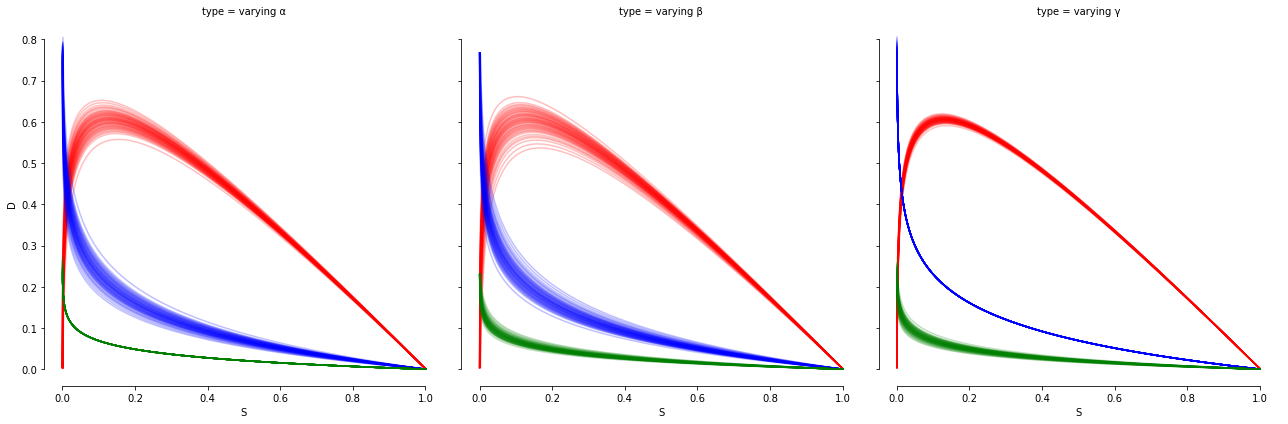

In [379]:
fg = sns.FacetGrid(data=results, col='type', height=6)
fg.map_dataframe(sns.lineplot, "S", 'I', estimator=None, units='simulation_run', alpha=alpha, color='r')
fg.map_dataframe(sns.lineplot, "S", 'R', estimator=None, units='simulation_run', alpha=alpha, color='b')
fg.map_dataframe(sns.lineplot, "S", 'D', estimator=None, units='simulation_run', alpha=alpha, color='g')
sns.despine(fg.fig, trim=True)

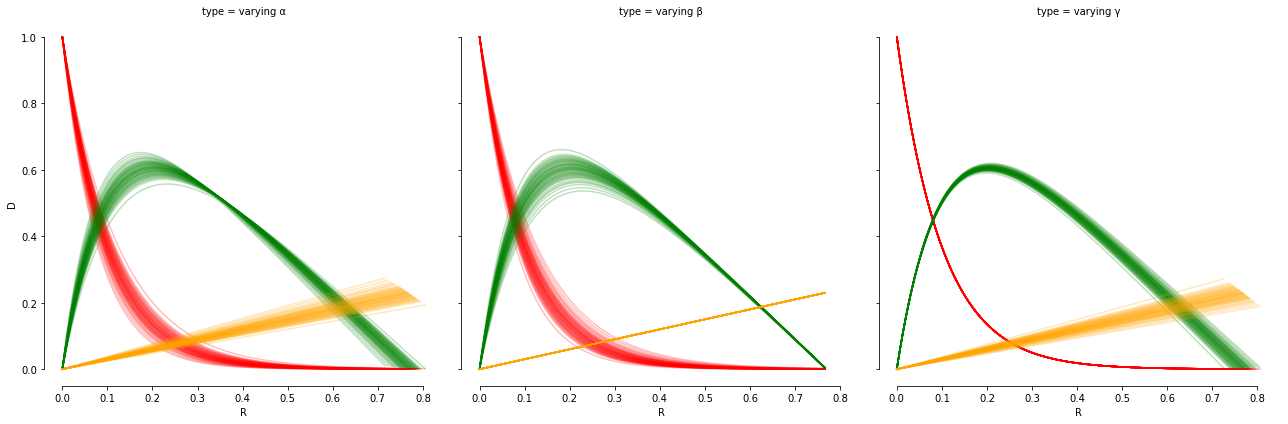

In [380]:
fg = sns.FacetGrid(data=results, col='type', height=6)
fg.map_dataframe(sns.lineplot, "R", 'S', estimator=None, units='simulation_run', alpha=alpha, color='r')
fg.map_dataframe(sns.lineplot, "R", 'I', estimator=None, units='simulation_run', alpha=alpha, color='g')
fg.map_dataframe(sns.lineplot, "R", 'D', estimator=None, units='simulation_run', alpha=alpha, color='orange')
sns.despine(fg.fig, trim=True)

To have a better understanding of the be behavior of the system, we could also fix a parameter and let the others change randomly.

By observing the resulting variance point by point we can infer the relevance of each parameter.

This is the basic approach for the global sensitivity analysis as used by Saltelli at al., and is the implementation basis of the SALib we saw last lesson.

# sampling with noise

a different approach to sensitity analysis is to try and generate random samples that replicate a possible measurement and try to fit the ODE parameters and observe how they change and covariate

In [381]:
scale = 100

time = np.linspace(0, 5, 2**5+1)
state0 = (1.0, 0.001, 0.0, 0.0)
α, β, γ = 1, 10, 0.3
res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
S_hat, I_hat, R_hat, D_hat = res.T

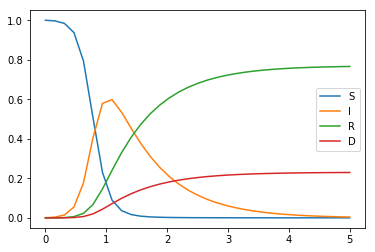

In [382]:
plt.plot(time, S_hat, label='S')
plt.plot(time, I_hat, label='I')
plt.plot(time, R_hat, label='R')
plt.plot(time, D_hat, label='D')

plt.legend()

the easiest way to do this is to use gaussian noise

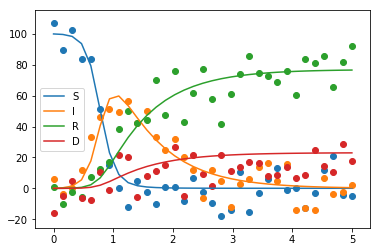

In [126]:
S_hat_normal, I_hat_normal, R_hat_normal, D_hat_normal = st.norm.rvs(loc=res*scale, scale=0.1*scale).T

plt.plot(time, S_hat*scale, label='S')
plt.plot(time, I_hat*scale, label='I')
plt.plot(time, R_hat*scale, label='R')
plt.plot(time, D_hat*scale, label='D')

plt.scatter(time, S_hat_normal)
plt.scatter(time, I_hat_normal)
plt.scatter(time, R_hat_normal)
plt.scatter(time, D_hat_normal)

plt.legend()

this clearly have problems, such as the population appearing negative!

we would be better using a different sampling such as the poisson distribution

In [127]:
st.poisson.rvs(res*scale)

array([[ 90,   0,   0,   0],
       [ 93,   0,   0,   0],
       [ 99,   2,   0,   0],
       [104,   3,   1,   1],
       [ 79,  13,   1,   0],
       [ 63,  40,   6,   1],
       [ 25,  57,   9,   2],
       [  7,  69,  27,   4],
       [  4,  52,  28,   9],
       [  2,  48,  34,  10],
       [  0,  36,  62,  15],
       [  1,  42,  55,  23],
       [  0,  20,  59,  20],
       [  0,  15,  53,  13],
       [  1,  22,  66,  19],
       [  0,   8,  69,  18],
       [  0,   8,  92,  21],
       [  0,   5,  83,  24],
       [  0,   3,  71,  18],
       [  0,   5,  65,  23],
       [  0,   6,  72,  20],
       [  0,   4,  63,  14],
       [  0,   6,  58,  17],
       [  0,   1,  66,  26],
       [  0,   6,  68,  24],
       [  0,   2,  78,  33],
       [  0,   1,  69,  16],
       [  0,   1,  68,  22],
       [  0,   1,  83,  15],
       [  0,   1,  92,  17],
       [  1,   0,  66,  24],
       [  0,   0,  88,  23],
       [  0,   1,  82,  26]])

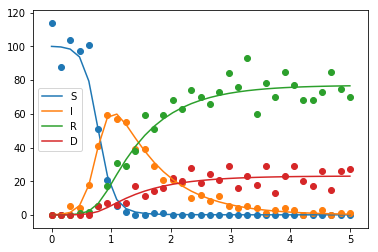

In [128]:
S_hat_poisson, I_hat_poisson, R_hat_poisson, D_hat_poisson = st.poisson.rvs(res*scale).T

plt.plot(time, S_hat*scale, label='S')
plt.plot(time, I_hat*scale, label='I')
plt.plot(time, R_hat*scale, label='R')
plt.plot(time, D_hat*scale, label='D')

plt.scatter(time, S_hat_poisson)
plt.scatter(time, I_hat_poisson)
plt.scatter(time, R_hat_poisson)
plt.scatter(time, D_hat_poisson)

plt.legend()

# fitting

now for the fitting procedure itself.

in a similar way to odeint, we will use a curve_fit function that will give use an estimate of the parameters and their correlations.

to do this, it takes a function that, given the x values and a set of parameters, it gives the prediction.

In [385]:
from scipy.optimize import curve_fit
# ydata = f(xdata, *params) + eps

let's study it with a linear regression first

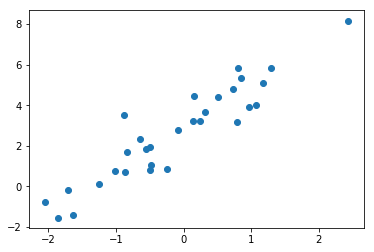

In [386]:
x = plt.randn(30)
y = 2*x + 3 + plt.randn(30)*0.8
plt.scatter(x, y)

In [387]:
def linear_fit(xdata, m, q):
    return m*xdata + q

p_avg, p_cov = curve_fit(linear_fit, x, y, p0=[1, 0])

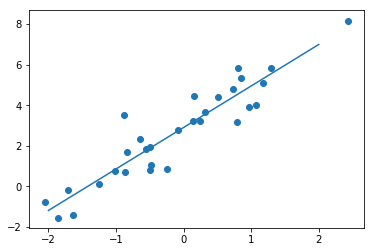

In [388]:
x_base = np.linspace(-2, 2, 51)
y_hat = linear_fit(x_base, *p_avg)
plt.scatter(x, y)
plt.plot(x_base, y_hat)

## how to visualize uncertainty?

se use the normal sampling we used before!

we just need to implement a more refined mapper to include the effect of the covariance

In [389]:
class mapper_multivariate_normal:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        # we have to use the cholesky decomposition to generate the samples
        self.L = np.linalg.cholesky(cov)
        
    def __call__(self, quantiles):
        values_standard = st.norm.isf(quantiles)
        values =  values_standard @ self.L + self.mean
        return values    

In [390]:
mapper = mapper_multivariate_normal(mean=p_avg, cov=p_cov)
p_seq = a_generate(2, 20000, mapper=mapper)

In [391]:
p_seq.shape

(20000, 2)

In [392]:
p_avg

array([2.04684076, 2.90332859])

In [393]:
np.mean(p_seq, axis=0)

array([2.04678784, 2.9033091 ])

In [394]:
p_cov

array([[0.02267863, 0.00276321],
       [0.00276321, 0.02545558]])

In [395]:
np.cov(p_seq.T)

array([[0.02301737, 0.00290545],
       [0.00290545, 0.02511582]])

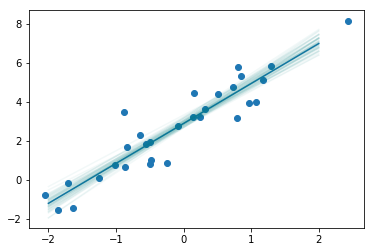

In [396]:
plt.scatter(x, y)

mapper = mapper_multivariate_normal(mean=p_avg, cov=p_cov)
p_seq = a_generate(2, 50, mapper=mapper)
x_base = np.linspace(-2, 2, 51)
y_hat = linear_fit(x_base, *p_avg)
plt.plot(x_base, y_hat)

for params in p_seq:
    y_hat = linear_fit(x_base, *params)
    plt.plot(x_base, y_hat, color='teal', alpha=0.05)

if one does not have access to a low discrepancy sequence, it might use just normal random generation, but will be limited in the precision that they can obtain

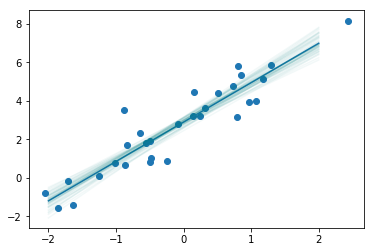

In [397]:
plt.scatter(x, y)

p_seq = st.multivariate_normal.rvs(mean=p_avg, cov=p_cov, size=50)
x_base = np.linspace(-2, 2, 51)
y_hat = linear_fit(x_base, *p_avg)
plt.plot(x_base, y_hat)

for params in p_seq:
    y_hat = linear_fit(x_base, *params)
    plt.plot(x_base, y_hat, color='teal', alpha=0.05)

a better visualization can be done using the 95% quantiles representation

In [398]:
from scipy.stats.mstats import mquantiles

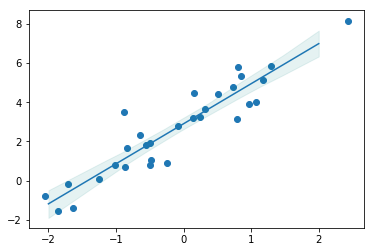

In [412]:
plt.scatter(x, y)

p_seq = st.multivariate_normal.rvs(mean=p_avg, cov=p_cov, size=50)
x_base = np.linspace(-2, 2, 101)
y_hat = linear_fit(x_base, *p_avg)
plt.plot(x_base, y_hat)
y_hat = [linear_fit(x_base, *params) for params in p_seq]
y_hat = np.stack(y_hat)

p_low, p_top = mquantiles(y_hat, prob=[0.025, 0.975], axis=0)
plt.fill_between(x_base, p_low, p_top, alpha=0.1, color='teal')

# what about differential equations?

to keep it simple we will use a simpler differential equation, the harmonic oscillator

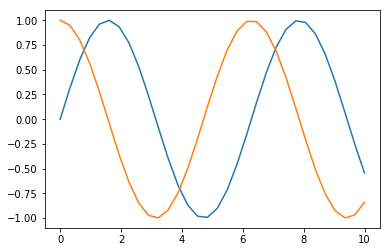

In [236]:
def harmonic(state, time, α, β):
    x, v = state
    return α*v, -β*x

time = np.linspace(0, 10, 2**5)
y0 = (0, 1)
res = odeint(harmonic, y0=y0, t=time, args=(1, 1))
X, V = res.T
plt.plot(time, X)
plt.plot(time, V)

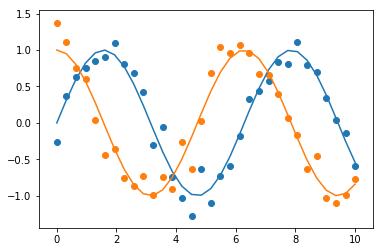

In [237]:
res_obs = res+plt.randn(*res.shape)*0.2
X_obs, V_obs = res_obs.T
plt.plot(time, X)
plt.plot(time, V)
plt.scatter(time, X_obs)
plt.scatter(time, V_obs)

to use in the fit, one just nesds to generate the data from the differential equation inside the function to be given to the fit function.

They only caveat is that we have un unravel the array so that it only has one dimension

In [278]:
def harmonic_fit(xdata, α, β):
    time = np.linspace(0, 5, 2**5)
    y0 = (0, 1)
    res = odeint(harmonic, y0=y0, t=xdata, args=(α, β))
    return res.ravel()

p_avg, p_cov = curve_fit(harmonic_fit, time, res_obs.ravel(), p0=[0.9, 1.1]) # try 0.5, 0.5

In [279]:
p_avg

array([1.00336555, 0.99768961])

In [280]:
p_cov

array([[ 0.00211465, -0.00204408],
       [-0.00204408,  0.00208822]])

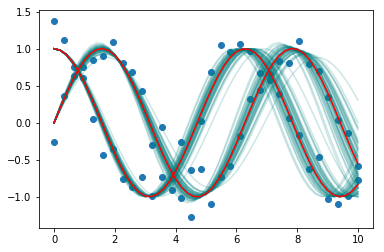

In [285]:
plt.scatter(xdata, ydata)

mapper = mapper_multivariate_normal(mean=p_avg, cov=p_cov)
p_seq = a_generate(2, 50, mapper=mapper)
x_base = np.linspace(0, 10, 51)


for params in p_seq:
    y_hat = harmonic_fit(x_base, *params).reshape(-1, 2)
    plt.plot(x_base, y_hat, color='teal', alpha=0.2)
    
y_hat = harmonic_fit(x_base, *p_avg).reshape(-1, 2)
plt.plot(x_base, y_hat, color='r')